How are we handling connectome with delays in Jax? tl;dr jump down to bottom, the forward and backwards passes are
```python
def fwd(buffer):
    return jnp.sum(weights*buffer[ns,lengths], axis=1)

def vjp(g,buffer):
    gb = jnp.tile(g[:,None],(1,nn)) # rev of sum(a, axis=1)
    return jnp.zeros_like(buffer).at[ns,lengths.T].add(weights.T*gb)
```

In practice the g_buffer needs to be reused & accumulate gradients from multiple time steps into same buffer otherwise perf will be terrible.

In [1]:
%pylab inline
import numpy as np
import jax
import jax.numpy as jnp

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [243]:
keys = jax.random.split(jax.random.PRNGKey(0), 10)
nn = 84
weights = jax.random.normal (keys[0], (nn, nn))
lengths = jax.random.randint(keys[1], (nn, nn), 0, 255)

Here's our buffer

In [3]:
buffer = jax.random.normal(keys[2], (nn, lengths.max()+1))

How to do this in jax?

In [4]:
# don't bother with @jax.jit
def cfun1(weights, lengths, buffer):
    nn = weights.shape[0]
    aff = []
    for i in range(nn):
        acc = 0
        for j in range(nn):
            acc += weights[i,j] * buffer[j, lengths[i,j]]
        aff.append(acc)
    return jnp.array(aff)

aff1 = cfun1(weights, lengths, buffer)

This is slow, and JIT compiling will unroll the nested loops completely, making this hazardous except that it's obviously correct with the explicit loop.

Numba is good with explicit loops

In [7]:
import numba as nb

@nb.njit
def cfun2(aff, weights, lengths, buffer):
    nn = weights.shape[0]
    for i in range(nn):
        acc = nb.float32(0)
        for j in range(nn):
            acc += weights[i,j] * buffer[j, lengths[i,j]]
        aff[i] = acc  

aff2 = np.zeros_like(aff1)
npargs = [np.array(_) for _ in (weights, lengths, buffer)]
cfun2(aff2, *npargs)
np.testing.assert_allclose(aff1, aff2)
%timeit cfun2(aff2, *npargs)

5.89 µs ± 22.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


So that's a nicer baseline to start with, too bad Numba doesn't autodiff.

Before vectorizing, let's try a `scan` w/ Jax

In [21]:
def cfun3(weights, lengths, buffer):
    js = jnp.r_[:weights.shape[0]]
    def do_ij(acc, jwl):
        j,w,l = jwl
        acc = acc + w * buffer[j, l]
        return acc, j
    def do_i(_, i):
        return _, jax.lax.scan(do_ij, 0.0, (js,weights[i],lengths[i]))[0]
    _, aff = jax.lax.scan(do_i, 0, js)
    return aff

cfun3j = jax.jit(cfun3)
aff3 = cfun3j(weights, lengths, buffer)
np.testing.assert_allclose(aff1, aff3, 1e-5, 1e-5)
%timeit cfun3j(weights, lengths, buffer).block_until_ready()

12.1 µs ± 190 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


This has a nicely functional flavor to it and is certainly ok speed wise, assuming Jax transforms apply nicely.  How does it do with batching?

In [23]:
cfun3_batch = jax.jit(jax.vmap(lambda b: cfun3(weights, lengths, b)))
for batch_size in [1, 2, 4, 8, 16]:
    buffer_batch = jax.random.normal(keys[2], (batch_size, nn, lengths.max()+1))
    cfun3_batch(buffer_batch)
    %timeit cfun3_batch(buffer_batch).block_until_ready()

11.4 µs ± 14.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
12.1 µs ± 50.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
54.6 µs ± 24.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
85.7 µs ± 64.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
127 µs ± 532 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


This isn't quite what we want: if batches are stride 1, then because of random memory access, extra batches should be +/- free.  Maybe `jax.vmap` can do that if we ask nicely?

In [30]:
cfun3_batch = jax.jit(jax.vmap(lambda b: cfun3(weights, lengths, b), 2))
for batch_size in [1, 2, 4, 8, 16]:
    buffer_batch = jax.random.normal(keys[2], (nn, lengths.max()+1, batch_size))
    cfun3_batch(buffer_batch)
    %timeit cfun3_batch(buffer_batch).block_until_ready()

11.4 µs ± 24.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
17.7 µs ± 87.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
72.9 µs ± 25.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
159 µs ± 36.2 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
263 µs ± 728 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Nope! Compare with handwritten

In [34]:
@jax.jit
def cfun3b(weights, lengths, buffer_batch):
    js = jnp.r_[:weights.shape[0]]
    batch_zero = jnp.zeros((buffer_batch.shape[-1],))
    def do_ij(acc, jwl):
        j,w,l = jwl
        acc = acc + w * buffer_batch[j, l]
        return acc, j
    def do_i(_, i):
        return _, jax.lax.scan(do_ij, batch_zero, (js,weights[i],lengths[i]))[0]
    _, aff = jax.lax.scan(do_i, 0, js)
    return aff

for batch_size in [1, 2, 4, 8, 16, 128]:
    buffer_batch = jax.random.normal(keys[2], (nn, lengths.max()+1, batch_size))
    cfun3b(weights, lengths, buffer_batch)
    %timeit cfun3b(weights, lengths, buffer_batch).block_until_ready()

12 µs ± 54 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
12.2 µs ± 21.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
12.3 µs ± 72.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
39.9 µs ± 40.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
55.3 µs ± 86.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
109 µs ± 418 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


That's more like it: we get a batch of 4 for the price of 1, batch of 128 for price of 10, and should scale further on wide lane hardware like GPU.  Tbh, it's not much harder to read/write: we just changed the initial value for the inner scan.

Seems like just a neat trick until inference on long time series where we will make heavy use of batching over time windows.

## autodiff

How well does autodiff work with this?

Start with a loss:

In [38]:
affb = cfun3b(weights, lengths, buffer_batch)

def loss(bb_hat):
    return jnp.sum((affb - cfun3b(weights, lengths, bb_hat))**2)

loss(buffer_batch), loss(buffer_batch + 1)

(Array(0., dtype=float32), Array(1110308.4, dtype=float32))

now grads

In [41]:
g_loss = jax.jit(jax.grad(loss))
g_loss(buffer_batch + 1)
%timeit g_loss(buffer_batch + 1)

46.7 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


oops that's slow!

In [42]:
for batch_size in [1, 2, 4, 8, 16, 128]:
    buffer_batch = jax.random.normal(keys[2], (nn, lengths.max()+1, batch_size))
    affb = cfun3b(weights, lengths, buffer_batch)
    def loss(bb_hat):
        return jnp.sum((affb - cfun3b(weights, lengths, bb_hat))**2)
    g_loss = jax.jit(jax.grad(loss))
    g_loss(buffer_batch + 1)
    %timeit cfun3b(weights, lengths, buffer_batch).block_until_ready()
    %timeit g_loss(buffer_batch + 1).block_until_ready()

11.9 µs ± 12.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
959 µs ± 171 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
12.2 µs ± 34.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
1.33 ms ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
12.3 µs ± 2.26 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
3.77 ms ± 4.21 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
39.7 µs ± 18.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.88 ms ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
55.6 µs ± 483 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
4.61 ms ± 82.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
109 µs ± 28.1 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
45.5 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Vectorizing the loop makes the code simpler but not better vjp perf:

In [91]:
@jax.jit
def cfun4(weights, lengths, buffer):
    def do_i(_, wl):
        w, l = wl
        return _, w @ buffer[jnp.r_[:nn], l]
    return jax.lax.scan(do_i, 0, (weights, lengths))[1]

aff4 = cfun4(weights, lengths, buffer)
np.testing.assert_allclose(aff1, aff4, 1e-5, 1e-5)
%timeit cfun4(weights, lengths, buffer)

gl = jax.grad(lambda b: jnp.sum((aff4 - cfun4(weights, lengths, b))**2))
gl(buffer+1)
%timeit gl(buffer+1)

11.9 µs ± 58.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
1.93 ms ± 1.64 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## backwards by hand

the backwards pass is provided by a vector-Jacobian product function or VJP

In [71]:
def cfun1(weights, lengths, buffer):
    nn = weights.shape[0]
    aff = []
    for i in range(nn):
        acc = 0
        for j in range(nn):
            acc += weights[i,j] * buffer[j, lengths[i,j]]
        aff.append(acc)
    return jnp.array(aff)

aff1 = cfun1(weights, lengths, buffer)

In [92]:
import numba 
np_buffer = np.array(buffer)
@numba.jit
def vjp_cfun1(g_aff, weights, lengths):
    # return g_buffer
    g_buffer = np.zeros_like(np_buffer)
    for i in range(nn):
        for j in range(nn):
            g_buffer[j, lengths[i,j]] += 1 #g_aff[i]*weights[i,j]/nn
    return g_buffer

g_aff1 = np.ones(nn)
g_buf1 = vjp_cfun1(g_aff1, np.array(weights), np.array(lengths))

So the perf is not dissimilar from before, just has random writes *but see below the result is wrong*

- [ ] check this against the Jax version
- [x] check perf in Numba
- [ ] how to get that random write pattern in Jax?
- [ ] reorganize vjp loops for a random read for a clean scan scan structure?

How can we get an equivalent function in Jax?

In [77]:
@jax.jit
def vjp_cfun3(g_aff, weights, lengths):
    return g_aff @ jax.jacrev(lambda b: cfun3(weights,lengths,b))(buffer)

g_aff3 = jnp.ones(nn)
g_buf3 = vjp_cfun3(g_aff3, weights, lengths)
np.testing.assert_allclose(g_buf1, g_buf3)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 10318 / 21420 (48.2%)
Max absolute difference: 5.1995068
Max relative difference: 40.262993
 x: array([[ 0.      ,  0.      ,  0.      , ...,  0.      , -0.010414,
         0.007804],
       [ 0.029223, -0.014523,  0.      , ...,  0.      ,  0.      ,...
 y: array([[ 0.273139,  0.491836,  0.      , ...,  0.      ,  0.      ,
        -0.66439 ],
       [ 0.      , -1.219954,  0.      , ...,  1.246804,  0.      ,...

Let's try a simpler problem, just one afferent value,

In [84]:
weights[0]@buffer[jnp.r_[:nn],lengths[0]], aff1[0]

(Array(7.187064, dtype=float32), Array(7.187065, dtype=float32))

From this we can see that the single value of `g_aff1[0]` requires writes to, potentially, any elements of `g_buffer`: one per row at `g_buffer[i, length[0,i]]`.  Can't we invert this by indexing into `g_aff1`? Not really.. we need an efficient way to create a sparse output.  Maybe we can generate a sparse matrix directly?

In [111]:
def cfun5i(weights, lengths, buffer, i):
    return jnp.dot(jnp.ones(nn), buffer[jnp.r_[:nn],lengths[i]])

g = jax.grad(lambda b: jnp.sum(cfun5i(weights, lengths, b, 0)**2))(buffer)

np.testing.assert_allclose(jnp.argwhere(g>0), jnp.c_[jnp.r_[:nn], lengths[0]])

In [120]:
g2 = np.zeros_like(g)
g2[np.r_[:nn],lengths[0]] += 1

In [125]:
np.testing.assert_allclose(g>0, g2)

So it looks like it's pretty simple and could be expressed tensor wise just as a sequence of increments with the `new_jax_array = jax_array.at[::2, 3:].add(7.)` syntax. Or even simply, we tell Jax to compute these in single array op so hopefully it behaves correctly:

In [140]:
@jax.jit
def cfun5(weights, lengths, buffer):
    return jnp.sum(weights*buffer[jnp.tile(jnp.arange(nn),(nn,1)),lengths], axis=1)

aff5 = cfun5(weights, lengths, buffer)
np.testing.assert_allclose(aff5, aff1, 1e-5, 1e-5)
%timeit cfun5(weights, lengths, buffer).block_until_ready()

gl = jax.grad(lambda b: jnp.sum((aff5 - cfun5(weights, lengths, b))**2))
gl(buffer+1)
%timeit gl(buffer+1).block_until_ready()

13.1 µs ± 74.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
1.1 ms ± 4.56 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Still a no go.. let's check the jac

In [143]:
J = jax.jacrev(lambda b: cfun5(weights, lengths, b))(buffer)
J.shape

(84, 84, 255)

In [161]:
def myJ():
    Ji = np.zeros((nn, nn, 255))
    for i in range(nn):
        Ji[i,np.r_[:nn],lengths[i]] += weights[i]
    return Ji
    
assert np.allclose(J, myJ())

(84,)


In [166]:
Ji = np.zeros((nn, nn, 255))
nc, nr = np.c_[:nn], np.r_[:nn]
Ji[nc, nr, lengths] += weights
np.testing.assert_allclose(J, Ji)
Ji.shape

(84, 84, 255)

In the linear case, this can be static,

In [169]:
@jax.jit
def revcfun5(g):
    return jnp.dot(g, Ji)

revcfun5(g_aff1)
%timeit revcfun5(g_aff1).block_until_ready()

105 µs ± 101 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


but in general we'd need to eval in the loop for an existing buffer e.g.

In [ ]:
@jax.jit
def revcfun6(g_aff, g_buffer):
    g_buffer.at[nc, nr,]

but the explicit Jacobian is memory expensive.  Can we do just the VJP?

In [192]:
@jax.jit
def vjpcfun5(g_aff):
    g_buf = jnp.zeros((nn, 255))
    # buffer[jnp.tile(jnp.arange(nn),(nn,1)),lengths] (84,84)
    # jnp.sum(weights*b[], axis=1)
    return g_buf.at[nr, lengths].add(g_aff[:,None] * weights)

print(vjpcfun5(g_aff1))
%timeit vjpcfun5(g_aff1)

[[ 0.          0.          0.         ...  0.         -0.874768
   0.6555433 ]
 [ 2.4547248  -1.2199535   0.         ...  0.          0.
  -1.0467068 ]
 [ 0.          0.6704424   0.         ...  0.          0.
   0.        ]
 ...
 [ 0.35021114  0.          0.         ...  0.09017821  0.
   0.        ]
 [ 0.          0.          0.9938805  ... -0.4928876   0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.4308036
  -0.5612956 ]]
28.4 µs ± 1.66 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [201]:
g__ = np.zeros(nn)
g__[0] = 1.0
(np.abs(jnp.dot(g__, J))>0).sum() == 84

True

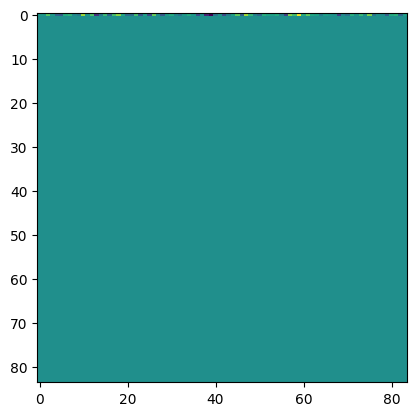

In [203]:
imshow(g__[:,None]*weights)

In [221]:
g_buf = np.zeros((nn, 255))
# buffer[jnp.tile(jnp.arange(nn),(nn,1)),lengths] (84,84)
# jnp.sum(weights*b[], axis=1)
g_buf[np.tile(np.arange(nn),(nn,1)), lengths] += (g__[:,None]  @ weights)[:,None]

plot(jnp.dot(g__, J).reshape(-1), g_buf.reshape(-1), '.')

TypeError: dot_general requires contracting dimensions to have the same shape, got (1,) and (84,).

let's break it down then, how to reverse mode `buffer[jnp.tile(jnp.arange(nn),(nn,1)),lengths]`?

In [ ]:
def foo(buffer):
    return jnp.sum(buffer[jnp.tile(jnp.arange(nn),(nn,1)),lengths])

gfoo1 = jax.grad(foo)

def gfoo2(buffer):
    return jnp.zeros_like(buffer).at[jnp.tile(jnp.arange(nn),(nn,1)),lengths].add(1)

np.testing.assert_allclose(gfoo1(buffer), gfoo2(buffer))

In [281]:
def foo(buffer):
    return buffer[jnp.tile(jnp.arange(nn),(nn,1)),lengths]

g = jnp.r_[:84*84]
J_foo = jax.jacrev(foo)(buffer).reshape((-1, nn, 255))

vjp_foo = jnp.sum(g[:,None,None] * J_foo, axis=0)

vjp_foo

Array([[    0.,     0.,     0., ...,     0.,  4956.,  2436.],
       [ 8319.,    85.,     0., ...,     0.,     0.,  6553.],
       [    0.,  1010.,     0., ...,     0.,     0.,     0.],
       ...,
       [  501.,     0.,     0., ...,  6213.,     0.,     0.],
       [    0.,     0.,  3526., ...,  3694.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,  8650., 11674.]],      dtype=float32)

In [282]:
def vjp_foo2(g, buffer):
    return jnp.zeros_like(buffer).at[jnp.tile(jnp.arange(nn),(nn,1)),lengths].add(g.reshape((nn, nn)))

np.testing.assert_allclose(vjp_foo, vjp_foo2(g, buffer))
vjp_foo2(g, buffer)

Array([[    0.,     0.,     0., ...,     0.,  4956.,  2436.],
       [ 8319.,    85.,     0., ...,     0.,     0.,  6553.],
       [    0.,  1010.,     0., ...,     0.,     0.,     0.],
       ...,
       [  501.,     0.,     0., ...,  6213.,     0.,     0.],
       [    0.,     0.,  3526., ...,  3694.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,  8650., 11674.]],      dtype=float32)

and the sum over row?

In [268]:
def sum_rows(A):
    return jnp.sum(A, axis=1)

g_sum_rows1 = jax.jacrev(sum_rows)

def vjp_sum_rows2(g,A):
    return jnp.tile(g[:,None],(1,A.shape[1]))

np.testing.assert_allclose(jnp.r_[:nn] @ g_sum_rows1(buffer),
                           vjp_sum_rows2(jnp.r_[:nn], buffer))

Let's try to combine the two, with weights too,

In [313]:
ns = jnp.tile(jnp.arange(nn),(nn,1))

def foo(buffer):
    b = buffer[ns,lengths]
    return jnp.sum(weights*b, axis=1)  # what is rev pass for this??

gfoo1 = jax.jacrev(foo)

def vjpfoo(g,buffer):
    gb = jnp.tile(g[:,None],(1,nn)) # rev of sum(b,axis=1)
    gbuf = jnp.zeros_like(buffer).at[ns,lengths.T].add(weights.T*gb) # lengths.T?
    return gbuf 

gaff = np.r_[:nn]
np.testing.assert_allclose(gaff@gfoo1(buffer), vjpfoo(gaff,buffer), 1e-5, 1e-5)

np.testing.assert_allclose(foo(buffer), aff1, 1e-5, 1e-5)

ff = jax.jit(foo)
vf = jax.jit(vjpfoo)
%timeit ff(buffer)
%timeit vf(gaff,buffer)

13.3 µs ± 21.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
26.3 µs ± 81 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


So now we've got a connectome impl which matches our naive impl but has an expected autodiff perf (~2x slower).